## **LOADING DATA**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from datetime import datetime as dt
from calendar import month_abbr
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,r2_score
import optuna
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv(r"C:\Users\Admin\Desktop\Data projects\python\Decision-making-system\SOURCE\store_data\FORECASTING BUSINESS PERFORMANCE.csv")  

In [3]:
df.head()

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,"$19,648.44","$12,309.75"
1,781,12/03/2014,90501,16,"$20,351.52","$13,497.13"
2,2090,29/11/2013,44460,26,"$111,367.62","$91,488.50"
3,1116,29/08/2018,30122,12,"$36,280.44","$21,967.81"
4,993,27/04/2013,75789,14,"$55,557.18","$48,645.87"


In [4]:
df.shape

(976243, 6)

## **PROCESS DATA**

In [5]:
df_model = df.copy()

In [6]:
df_model.isnull().sum()
df_model.dropna(inplace=True)

In [7]:
df_model.columns = df_model.columns.str.strip()
df_model

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,"$19,648.44","$12,309.75"
1,781,12/03/2014,90501,16,"$20,351.52","$13,497.13"
2,2090,29/11/2013,44460,26,"$111,367.62","$91,488.50"
3,1116,29/08/2018,30122,12,"$36,280.44","$21,967.81"
4,993,27/04/2013,75789,14,"$55,557.18","$48,645.87"
...,...,...,...,...,...,...
976238,2213,12/08/2013,15135,1,"$1,070.37",$749.79
976239,2213,04/12/2011,80120,1,"$1,070.37",$749.79
976240,2213,29/05/2011,30028,1,"$1,070.37",$749.79
976241,2213,01/04/2014,65279,1,"$1,070.37",$749.79


In [8]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976202 entries, 0 to 976242
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductID  976202 non-null  int64 
 1   Date       976202 non-null  object
 2   Zip        976202 non-null  int64 
 3   Units      976202 non-null  int64 
 4   Revenue    976202 non-null  object
 5   COGS       976202 non-null  object
dtypes: int64(3), object(3)
memory usage: 52.1+ MB


In [9]:
df_model['Revenue'] = df_model['Revenue'].str.replace('[\$,]', '', regex=True).astype(float)
df_model['COGS'] = df_model['COGS'].str.replace('[\$,]', '', regex=True).astype(float)

print(df_model.dtypes) 

ProductID      int64
Date          object
Zip            int64
Units          int64
Revenue      float64
COGS         float64
dtype: object


In [10]:
df_model

,ProductID,Date,Zip,Units,Revenue,COGS
0,1228,31/07/2013,78773,12,19648.44,12309.75
1,781,12/03/2014,90501,16,20351.52,13497.13
2,2090,29/11/2013,44460,26,111367.62,91488.50
3,1116,29/08/2018,30122,12,36280.44,21967.81
4,993,27/04/2013,75789,14,55557.18,48645.87
...,...,...,...,...,...,...
976238,2213,12/08/2013,15135,1,1070.37,749.79
976239,2213,04/12/2011,80120,1,1070.37,749.79
976240,2213,29/05/2011,30028,1,1070.37,749.79
976241,2213,01/04/2014,65279,1,1070.37,749.79


In [11]:
df_model[df_model['Revenue'] < 0]


,ProductID,Date,Zip,Units,Revenue,COGS


In [12]:
df_model['Profit'] = df_model['Revenue'] - df_model['COGS']
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model.drop(columns=['COGS','Revenue','ProductID','Zip'],inplace=True)

In [13]:
df_model

,Date,Units,Profit
0,2013-07-31,12,7338.69
1,2014-12-03,16,6854.39
2,2013-11-29,26,19879.12
3,2018-08-29,12,14312.63
4,2013-04-27,14,6911.31
...,...,...,...
976238,2013-12-08,1,320.58
976239,2011-04-12,1,320.58
976240,2011-05-29,1,320.58
976241,2014-01-04,1,320.58


In [14]:
df_daily = df_model.groupby('Date').agg({'Profit': 'sum', 'Units': 'sum'}).reset_index()

print(df_daily)


           Date     Profit  Units
0    2010-01-08  638593.92    681
1    2010-01-09   38493.72     21
2    2010-01-10  266312.86    202
3    2010-01-11   81025.77     46
4    2010-02-08  998737.64   1274
...         ...        ...    ...
4248 2022-12-02   62849.70     61
4249 2022-12-03  157933.19    153
4250 2022-12-04  200736.52    206
4251 2022-12-05  144340.54    139
4252 2022-12-06  175559.84    190

[4253 rows x 3 columns]


In [15]:
print('Starting date:',df_daily['Date'].min())
print('Ending date:',df_daily['Date'].max())

Starting date: 2010-01-08 00:00:00
Ending date: 2022-12-06 00:00:00


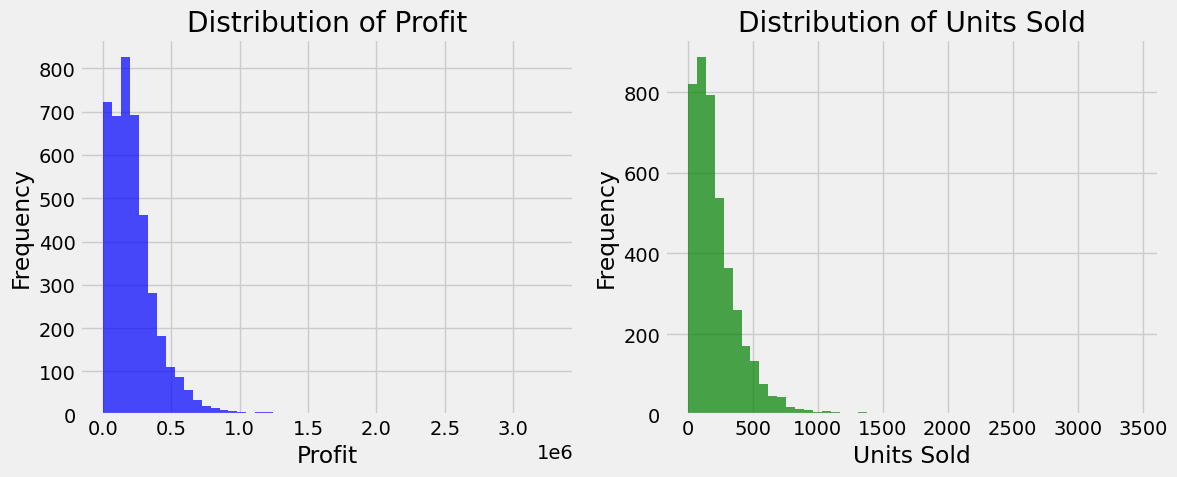

In [16]:

df_daily = df_daily.sort_values(by='Date')  

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_daily['Profit'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Profit')

plt.subplot(1, 2, 2)
plt.hist(df_daily['Units'], bins=50, color='green', alpha=0.7)
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.title('Distribution of Units Sold')

plt.tight_layout()
plt.show()




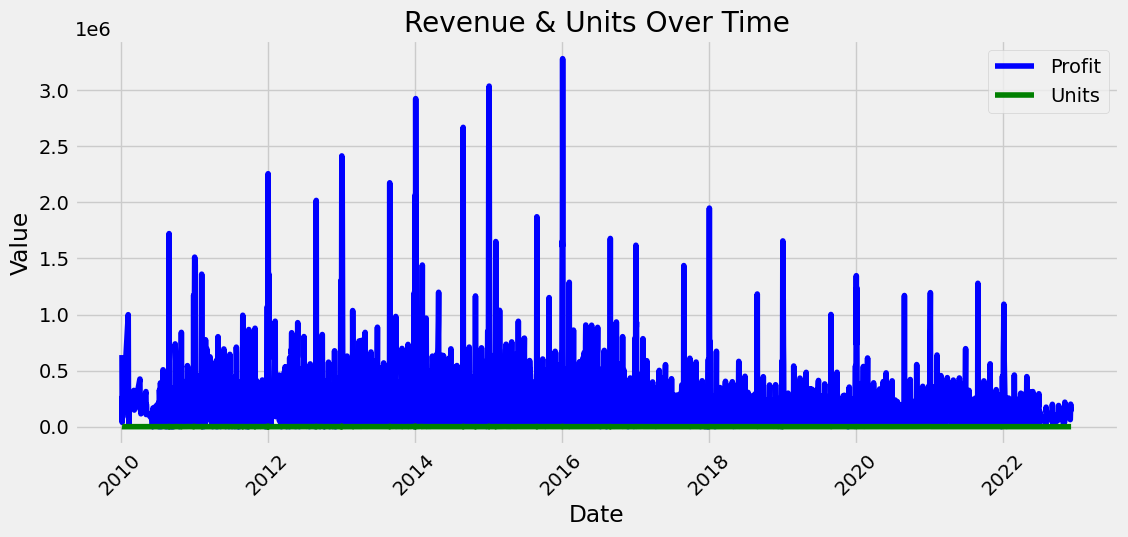

In [17]:
plt.figure(figsize=(12, 5))

plt.plot(df_daily['Date'], df_daily['Profit'], label='Profit', color='blue')
plt.plot(df_daily['Date'], df_daily['Units'], label='Units', color='green')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Revenue & Units Over Time')
plt.legend()
plt.xticks(rotation=45)  

plt.show()

In [18]:
loss_profit_rows = df_daily[df_daily['Profit']<= 0]

if not loss_profit_rows.empty:
    print(f"Có {len(loss_profit_rows)} dòng có Profit = 0:")
    print(loss_profit_rows[['Date', 'Units','Profit']]) 
else:
    print("Không có dòng nào có Profit <= 0.")


Có 19 dòng có Profit = 0:
           Date  Units   Profit
68   2010-08-20      1  -145.24
78   2010-08-31      1  -108.18
79   2010-09-07      2  -251.60
85   2010-09-14      1  -318.75
92   2010-09-21      1  -100.30
204  2011-02-11      1  -100.77
328  2011-06-23      1  -148.01
372  2011-08-07      1   -75.56
377  2011-08-12      1  -466.21
423  2011-09-28      1  -109.53
503  2011-12-22      1 -1200.62
834  2012-12-04      1 -1070.58
1215 2013-12-31      3   -81.16
2146 2016-08-11      1   -14.35
2252 2016-11-26      1  -193.48
2625 2017-12-13      2  -102.78
2637 2017-12-25      9  -932.22
3320 2019-11-24      2  -890.99
4068 2021-12-25      1   -34.11


In [19]:
def handle_outliers_iqr(df, columns):
    for column in columns:
        print(f"Cleaning column: {column}")
        print(f"Existing Min, Max Values: {df[column].agg([min, max])}")
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [20]:
df_cleaned = handle_outliers_iqr(df_daily,['Profit','Units'])
print(df_cleaned.shape)

Cleaning column: Profit
Existing Min, Max Values: min      -1200.62
max    3281361.19
Name: Profit, dtype: float64
Cleaning column: Units
Existing Min, Max Values: min       1
max    1084
Name: Units, dtype: int64
(3968, 3)


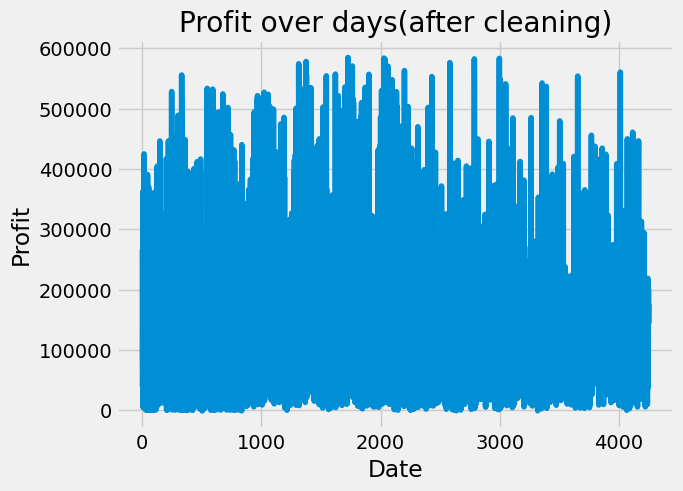

In [21]:
df_cleaned['Profit'].plot()
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit over days(after cleaning)')
plt.show()

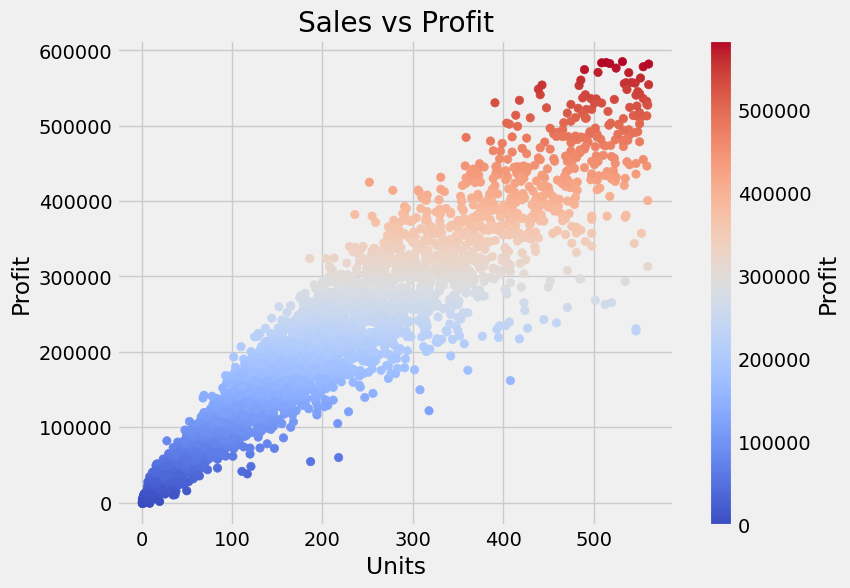

In [22]:

plt.figure(figsize=(8, 6))
scatter_plot = plt.scatter(df_cleaned['Units'], df_cleaned['Profit'], c=df_cleaned['Profit'], cmap='coolwarm')

plt.colorbar(label='Profit') 
plt.title('Sales vs Profit')
plt.xlabel('Units')
plt.ylabel('Profit')

plt.show()


In [23]:
df_cleaned

,Date,Profit,Units
1,2010-01-09,38493.72,21
2,2010-01-10,266312.86,202
3,2010-01-11,81025.77,46
5,2010-02-09,362939.20,394
6,2010-02-10,147927.78,167
...,...,...,...
4248,2022-12-02,62849.70,61
4249,2022-12-03,157933.19,153
4250,2022-12-04,200736.52,206
4251,2022-12-05,144340.54,139


In [24]:
df_cleaned.set_index("Date", inplace=True)


In [25]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3968 entries, 2010-01-09 to 2022-12-06
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Profit  3968 non-null   float64
 1   Units   3968 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 93.0 KB


## **Feature Engineering**



In [26]:
def time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_features = time_features(df_cleaned)


In [27]:
df_features

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2010-01-09,38493.72,21,5,1,1,2010,9,9,1
2010-01-10,266312.86,202,6,1,1,2010,10,10,1
2010-01-11,81025.77,46,0,1,1,2010,11,11,2
2010-02-09,362939.20,394,1,1,2,2010,40,9,6
2010-02-10,147927.78,167,2,1,2,2010,41,10,6
...,...,...,...,...,...,...,...,...,...
2022-12-02,62849.70,61,4,4,12,2022,336,2,48
2022-12-03,157933.19,153,5,4,12,2022,337,3,48
2022-12-04,200736.52,206,6,4,12,2022,338,4,48


In [28]:
def add_lags(df):
    target_map = df['Profit'].to_dict()
    # Short-term lags
    df['lag_1week'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_2weeks'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_1month'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    # Medium-term lags
    df['lag_quarter'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag_halfyear'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    # Yearly lags (maintaining weekday alignment)
    df['lag_1year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2years'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3years'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    # Same month previous years (handles varying month lengths)
    df['lag_1year_exact'] = df.index.map(lambda x: 
        target_map.get(x - pd.DateOffset(years=1), None))
    df['lag_2years_exact'] = df.index.map(lambda x: 
        target_map.get(x - pd.DateOffset(years=2), None))
    return df

In [29]:
df_features_lags = add_lags(df_features)


In [30]:
df_features_lags

,Profit,Units,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,,,,,
2010-01-09,38493.72,21,5,1,1,2010,9,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-10,266312.86,202,6,1,1,2010,10,10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,81025.77,46,0,1,1,2010,11,11,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-09,362939.20,394,1,1,2,2010,40,9,6,NaN,NaN,266312.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-10,147927.78,167,2,1,2,2010,41,10,6,NaN,NaN,81025.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-02,62849.70,61,4,4,12,2022,336,2,48,NaN,NaN,85786.05,66267.28,90067.71,39548.36,268410.27,190287.55,100411.20,19672.49
2022-12-03,157933.19,153,5,4,12,2022,337,3,48,NaN,NaN,35973.32,123300.53,93933.78,214048.28,222392.90,34462.34,39548.36,141714.73
2022-12-04,200736.52,206,6,4,12,2022,338,4,48,NaN,NaN,153168.09,199680.64,18091.19,278947.79,158529.45,151651.54,214048.28,268410.27


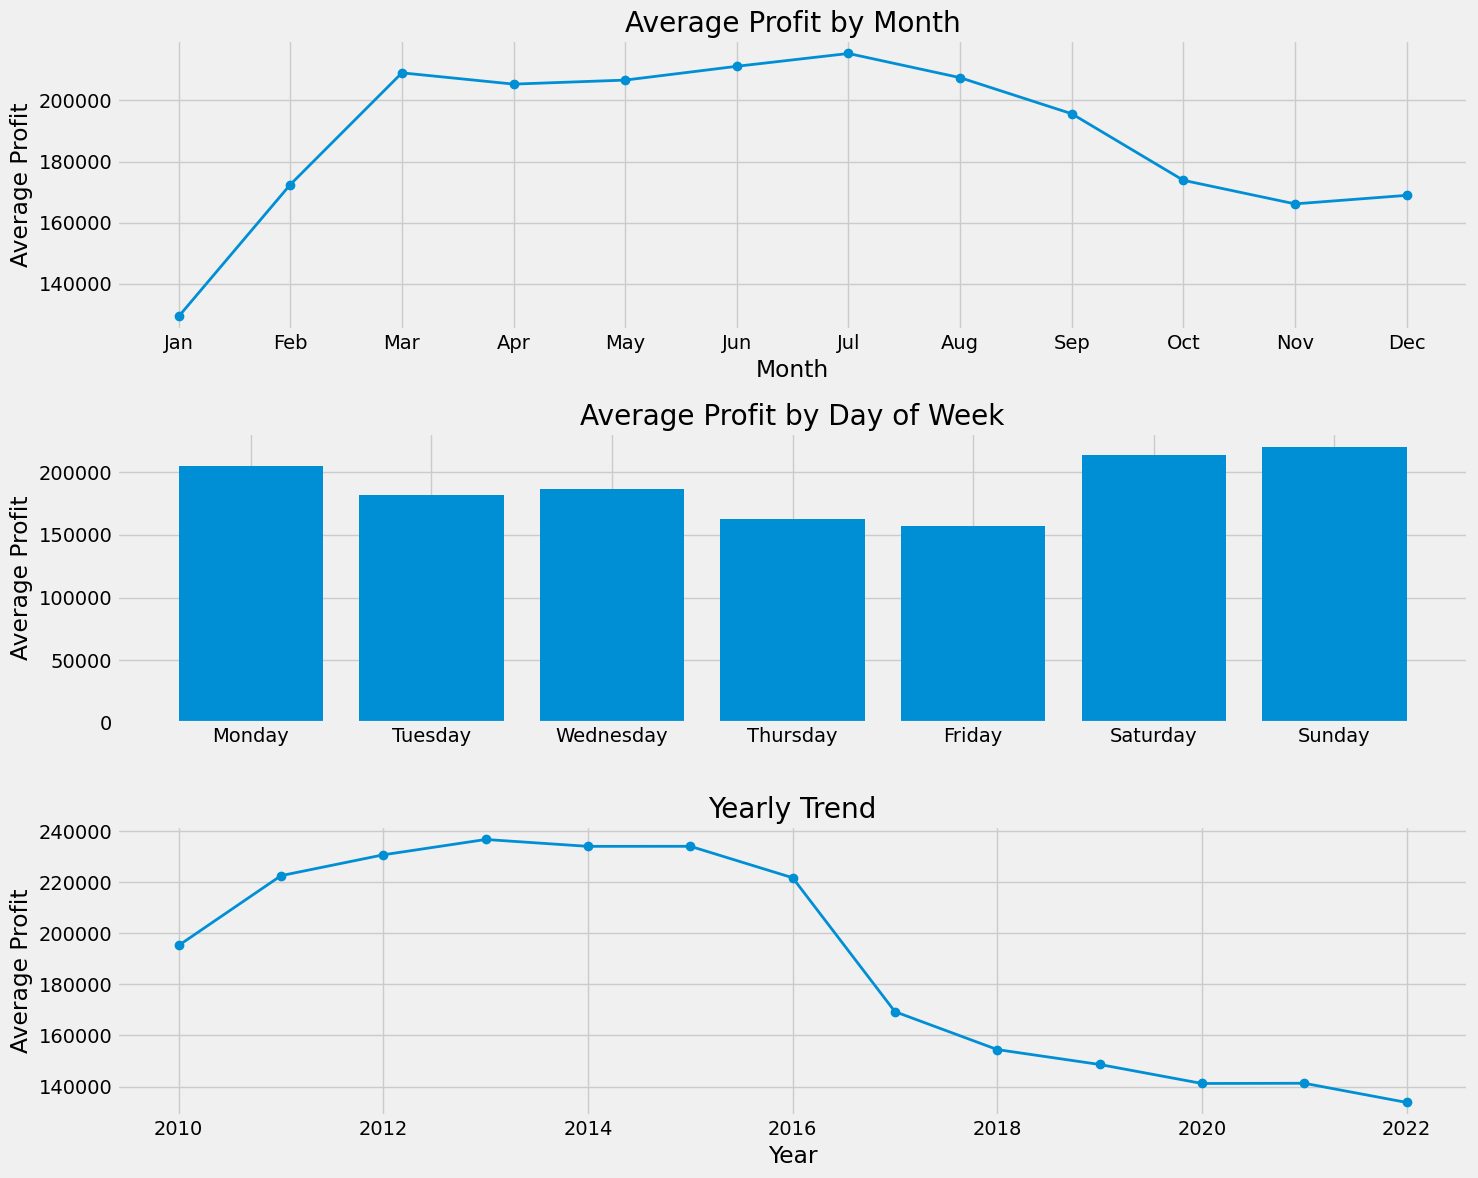

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(15, 12))  
monthly_avg = df_features_lags.groupby('month')['Profit'].mean()
ax[0].plot(range(1, 13), monthly_avg.values, marker='o', linewidth=2)
ax[0].set_xticks(range(1, 13))
ax[0].set_xticklabels([month_abbr[i] for i in range(1, 13)])
ax[0].set_title('Average Profit by Month')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Profit')
dow_avg = df_features_lags.groupby('dayofweek')['Profit'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax[1].bar(days, dow_avg.values)
ax[1].set_xticks(range(len(days)))  
ax[1].set_title('Average Profit by Day of Week')
ax[1].set_ylabel('Average Profit')
yearly_avg = df_features_lags.groupby('year')['Profit'].mean()
ax[2].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2)
ax[2].set_title('Yearly Trend')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Average Profit')
plt.tight_layout()  
plt.show()

## **FEATURES SELECTION**

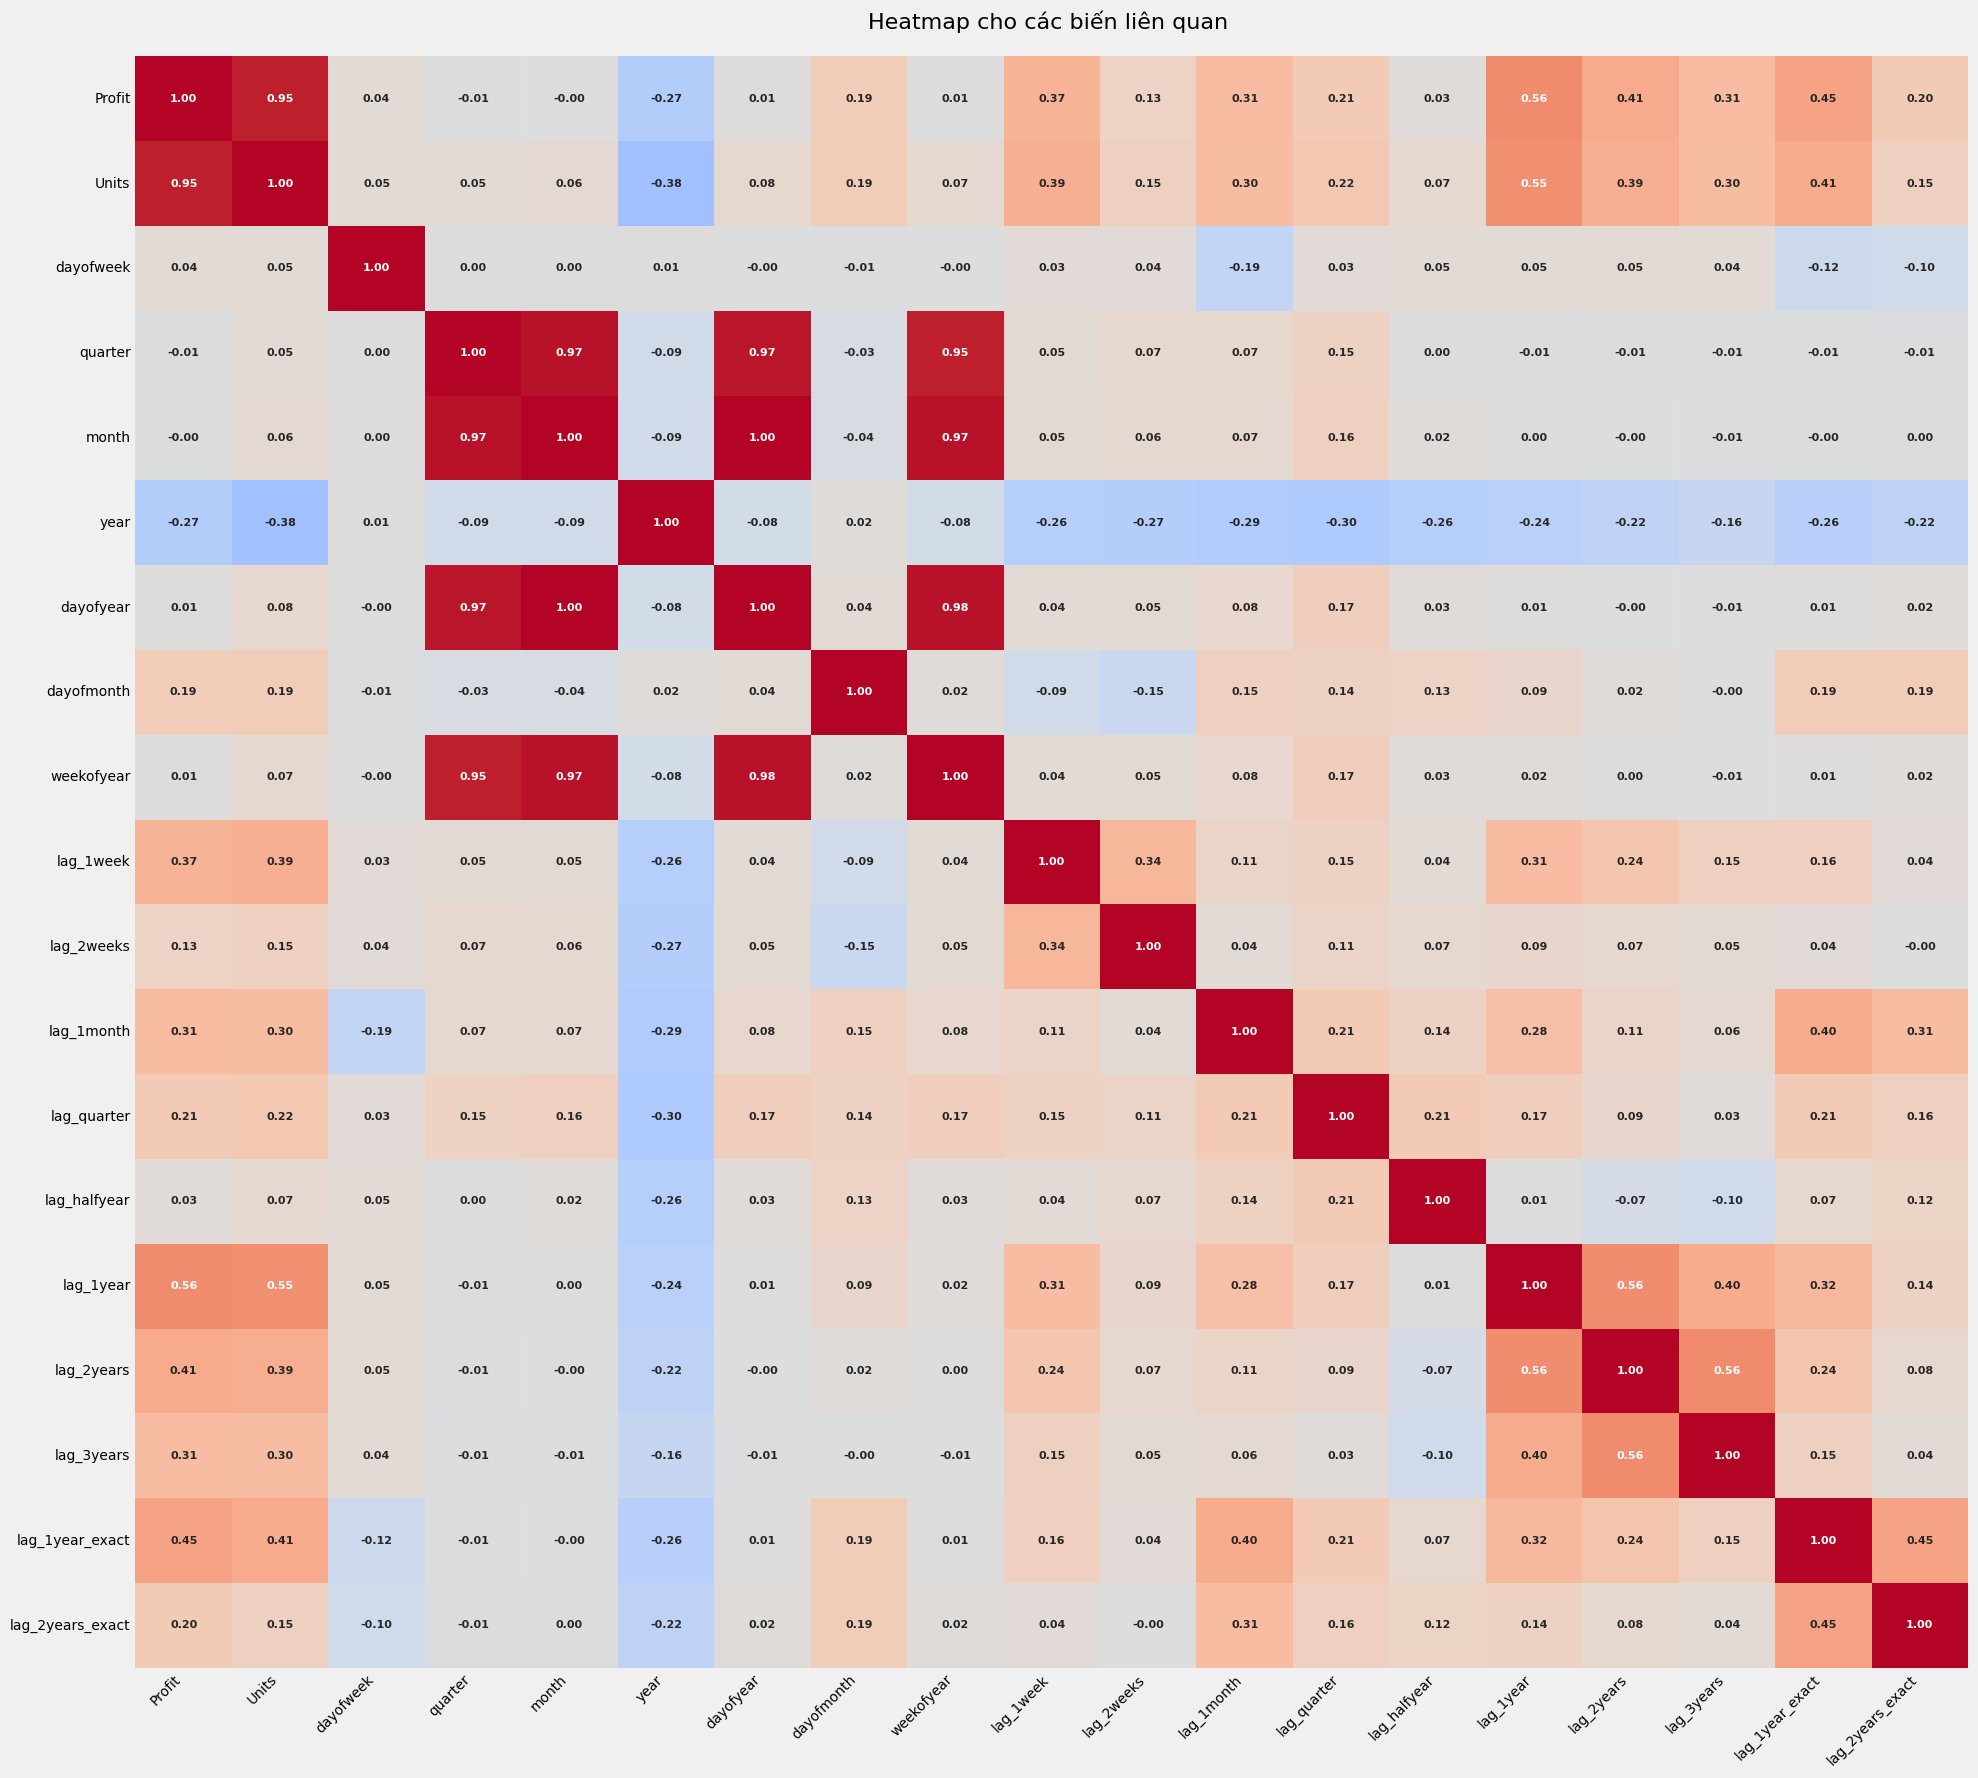

In [32]:
corr = df_features_lags.corr()

fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f',
            cmap='coolwarm', annot_kws={'fontsize': 8, 'fontweight': 'bold'}, cbar=False)

ax.tick_params(left=False, bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.title('Heatmap cho các biến liên quan ', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [33]:
corr_quality = corr['Profit']
corr_quality = corr_quality.abs().sort_values(ascending=False)
print('Correlation of Profit":')
print(corr_quality)

Correlation of Profit":
Profit              1.000000
Units               0.947210
lag_1year           0.563491
lag_1year_exact     0.451404
lag_2years          0.408179
lag_1week           0.366689
lag_1month          0.309573
lag_3years          0.308806
year                0.274933
lag_quarter         0.205025
lag_2years_exact    0.199741
dayofmonth          0.185038
lag_2weeks          0.127619
dayofweek           0.043776
lag_halfyear        0.031073
quarter             0.013120
dayofyear           0.012274
weekofyear          0.006064
month               0.002226
Name: Profit, dtype: float64


In [34]:
def corr_features(df, threshold: float):
    corr_pair = [] 
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > threshold :
                corr_pair.append((corr.columns[i], corr.columns[j], corr.iloc[i,j]))
    return corr_pair

In [35]:
correlated_features = corr_features(df_features_lags, 0.8)

In [36]:
correlated_features

[('Units', 'Profit', 0.9472099348940228),
 ('month', 'quarter', 0.9703268507128591),
 ('dayofyear', 'quarter', 0.9678924467767799),
 ('dayofyear', 'month', 0.9965652480044892),
 ('weekofyear', 'quarter', 0.9496933300628596),
 ('weekofyear', 'month', 0.974833656005338),
 ('weekofyear', 'dayofyear', 0.9764249012523509)]

In [37]:
drop_features = []
for i ,j, k in correlated_features:
    drop_features.append(i)
drop_features = list(set(drop_features))
drop_features

['Units', 'dayofyear', 'weekofyear', 'month']

In [38]:
df_model = df_features_lags.drop(columns=['Units',
 'month',
 'weekofyear',
 'dayofyear'], axis=1)


In [39]:
df_model

,Profit,dayofweek,quarter,year,dayofmonth,lag_1week,lag_2weeks,lag_1month,lag_quarter,lag_halfyear,lag_1year,lag_2years,lag_3years,lag_1year_exact,lag_2years_exact
Date,,,,,,,,,,,,,,,
2010-01-09,38493.72,5,1,2010,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-10,266312.86,6,1,2010,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,81025.77,0,1,2010,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-09,362939.20,1,1,2010,9,NaN,NaN,266312.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-10,147927.78,2,1,2010,10,NaN,NaN,81025.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-02,62849.70,4,4,2022,2,NaN,NaN,85786.05,66267.28,90067.71,39548.36,268410.27,190287.55,100411.20,19672.49
2022-12-03,157933.19,5,4,2022,3,NaN,NaN,35973.32,123300.53,93933.78,214048.28,222392.90,34462.34,39548.36,141714.73
2022-12-04,200736.52,6,4,2022,4,NaN,NaN,153168.09,199680.64,18091.19,278947.79,158529.45,151651.54,214048.28,268410.27


## **BUILD TRIALS MODELS**

In [40]:
feature = df_model.drop(['Profit'], axis=1).columns.to_list()
feature

['dayofweek',
 'quarter',
 'year',
 'dayofmonth',
 'lag_1week',
 'lag_2weeks',
 'lag_1month',
 'lag_quarter',
 'lag_halfyear',
 'lag_1year',
 'lag_2years',
 'lag_3years',
 'lag_1year_exact',
 'lag_2years_exact']

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_model['Profit'].values[:] = scaler.fit_transform(df_model['Profit'].values.reshape(-1, 1)).flatten()


In [42]:
tscv = TimeSeriesSplit(n_splits=3, test_size=int(0.2 * len(df_features_lags)), gap=24)
df_model = df_model.sort_index()

In [43]:
fold = 0
preds = []
scores = []
accs = []

for train_idx, val_idx in tscv.split(df_model):
    train = df_model.iloc[train_idx]
    test = df_model.iloc[val_idx]
    X_train = train[feature]
    y_train = train['Profit']
    X_test = test[feature]
    y_test = test['Profit']
    reg = xgb.XGBRegressor(n_estimators=1000,
                            learning_rate=0.01,
                            booster='gbtree',
                            max_depth=5,
                            objectives = 'reg:squarederror',
                            early_stopping_rounds=50
                            )
    reg.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)], 
        verbose=True  
    )
    pred = reg.predict(X_test)
    preds.append(pred)
    score = np.sqrt(mean_squared_error(y_test, pred))
    acc = r2_score(y_test, pred)
    accs.append(acc)
    scores.append(score)
    
    

[0]	validation_0-rmse:0.22852
[1]	validation_0-rmse:0.22748
[2]	validation_0-rmse:0.22646
[3]	validation_0-rmse:0.22545
[4]	validation_0-rmse:0.22444
[5]	validation_0-rmse:0.22348
[6]	validation_0-rmse:0.22253
[7]	validation_0-rmse:0.22159
[8]	validation_0-rmse:0.22070
[9]	validation_0-rmse:0.21980
[10]	validation_0-rmse:0.21891
[11]	validation_0-rmse:0.21807
[12]	validation_0-rmse:0.21722
[13]	validation_0-rmse:0.21639
[14]	validation_0-rmse:0.21558
[15]	validation_0-rmse:0.21477
[16]	validation_0-rmse:0.21402
[17]	validation_0-rmse:0.21325
[18]	validation_0-rmse:0.21247
[19]	validation_0-rmse:0.21172
[20]	validation_0-rmse:0.21104
[21]	validation_0-rmse:0.21033
[22]	validation_0-rmse:0.20964
[23]	validation_0-rmse:0.20897
[24]	validation_0-rmse:0.20829
[25]	validation_0-rmse:0.20763
[26]	validation_0-rmse:0.20701
[27]	validation_0-rmse:0.20637
[28]	validation_0-rmse:0.20577
[29]	validation_0-rmse:0.20516
[30]	validation_0-rmse:0.20457
[31]	validation_0-rmse:0.20396
[32]	validation_0-

In [44]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(accs)

Score across folds 0.1311
Fold scores:[0.17499344993408755, 0.11269431147137815, 0.10570345769303154]
[0.39642751746926974, 0.5946064271008256, 0.5240405794167359]


## **Optimization**

In [45]:
def trial_model(trial, X_train, y_train, X_val, y_val):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.05),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
    
    model = xgb.XGBRegressor(**param, objective='reg:squarederror')
    model.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             verbose=False)
    
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

In [ ]:
def train_evaluate_model(df_model, feature_cols, target_col='Profit', n_splits=3):
    tscv = TimeSeriesSplit(
        n_splits=n_splits, 
        test_size=int(0.2 * len(df_model)), 
        gap=24
    )
    results = {
        'fold_scores': [],
        'feature_importance': pd.DataFrame(),
        'best_parmas': [],
        'metrics': {
            'rmse': [],
            'mape': [],
            'r2': []
        }
    }
    for fold, (train_idx, val_idx) in enumerate(tscv.split(df_model)):
        print(f"\nTraining fold {fold + 1}/{n_splits}")
        train = df_model.iloc[train_idx]
        val = df_model.iloc[val_idx]
        X_train = train[feature_cols]
        y_train = train[target_col]
        X_val = val[feature_cols]
        y_val = val[target_col]
        
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: trial_model(trial, X_train, y_train, X_val, y_val), 
                    n_trials=20)
        best_params = study.best_params
        best_params['objective'] = 'reg:squarederror'
        results['best_parmas'].append(best_params)
        model = xgb.XGBRegressor(**best_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        mape = mean_absolute_percentage_error(y_val, val_pred) * 100
        r2 = r2_score(y_val, val_pred)
        results['metrics']['rmse'].append(rmse)
        results['metrics']['mape'].append(mape)
        results['metrics']['r2'].append(r2)
        fold_importance = pd.DataFrame({
            'feature': feature_cols,
            f'importance_fold_{fold}': model.feature_importances_
        })
        results['feature_importance'] = pd.concat([
            results['feature_importance'], 
            fold_importance
        ], axis=1)
        
        print(f"Fold {fold + 1} RMSE: {rmse:.2f}")
        print(f"Fold {fold + 1} MAPE: {mape:.2f}%")
        print(f"Fold {fold + 1} R2: {r2:.3f}")
    return results

In [47]:
results = train_evaluate_model(
    df_model=df_model,
    feature_cols=feature,
    target_col='Profit'
)

[I 2025-05-03 23:47:27,965] A new study created in memory with name: no-name-aeef4919-2058-4742-92ea-276b746f2565



Training fold 1/3


[I 2025-05-03 23:47:28,518] Trial 0 finished with value: 0.17745552620609378 and parameters: {'n_estimators': 771, 'max_depth': 4, 'learning_rate': 0.010030399169338101, 'subsample': 0.6733270578657068, 'colsample_bytree': 0.6448268592020162, 'min_child_weight': 3, 'reg_alpha': 2.515696417275076e-06, 'reg_lambda': 2.26393815264318e-06}. Best is trial 0 with value: 0.17745552620609378.
[I 2025-05-03 23:47:30,314] Trial 1 finished with value: 0.17759898138444657 and parameters: {'n_estimators': 2575, 'max_depth': 4, 'learning_rate': 0.004739715872977287, 'subsample': 0.6078839520770601, 'colsample_bytree': 0.8524772504060025, 'min_child_weight': 4, 'reg_alpha': 0.0002596072280612106, 'reg_lambda': 0.0029948093396436385}. Best is trial 0 with value: 0.17745552620609378.
[I 2025-05-03 23:47:30,998] Trial 2 finished with value: 0.17825892754962813 and parameters: {'n_estimators': 1307, 'max_depth': 3, 'learning_rate': 0.002217026812048093, 'subsample': 0.7847316686398652, 'colsample_bytree'

Fold 1 RMSE: 0.17
Fold 1 MAPE: 336.60%
Fold 1 R2: 0.437

Training fold 2/3


[I 2025-05-03 23:48:28,047] Trial 0 finished with value: 0.11002416803552147 and parameters: {'n_estimators': 2131, 'max_depth': 8, 'learning_rate': 0.009001613703584151, 'subsample': 0.641207505332832, 'colsample_bytree': 0.7762216655100683, 'min_child_weight': 7, 'reg_alpha': 0.0362403461189517, 'reg_lambda': 0.5770167441582157}. Best is trial 0 with value: 0.11002416803552147.
[I 2025-05-03 23:48:29,722] Trial 1 finished with value: 0.11198976046706532 and parameters: {'n_estimators': 1508, 'max_depth': 5, 'learning_rate': 0.003391436609446103, 'subsample': 0.756251726423653, 'colsample_bytree': 0.8025289190721782, 'min_child_weight': 5, 'reg_alpha': 4.138634770196406e-08, 'reg_lambda': 1.836373088369239e-07}. Best is trial 0 with value: 0.11002416803552147.
[I 2025-05-03 23:48:30,440] Trial 2 finished with value: 0.114762040868097 and parameters: {'n_estimators': 1013, 'max_depth': 3, 'learning_rate': 0.035931869324484736, 'subsample': 0.6396247888217478, 'colsample_bytree': 0.7129

Fold 2 RMSE: 0.11
Fold 2 MAPE: 163.95%
Fold 2 R2: 0.622

Training fold 3/3


[I 2025-05-03 23:49:39,649] Trial 0 finished with value: 0.10198527474036807 and parameters: {'n_estimators': 1458, 'max_depth': 5, 'learning_rate': 0.011299886560308624, 'subsample': 0.6270741353942079, 'colsample_bytree': 0.8134121869668913, 'min_child_weight': 7, 'reg_alpha': 2.16264910436516e-07, 'reg_lambda': 0.004952174845979894}. Best is trial 0 with value: 0.10198527474036807.
[I 2025-05-03 23:49:44,023] Trial 1 finished with value: 0.1017426499379314 and parameters: {'n_estimators': 1448, 'max_depth': 7, 'learning_rate': 0.003056220990346886, 'subsample': 0.7540092173099067, 'colsample_bytree': 0.7360780680347347, 'min_child_weight': 6, 'reg_alpha': 0.13486756147808607, 'reg_lambda': 8.386601063280425e-05}. Best is trial 1 with value: 0.1017426499379314.
[I 2025-05-03 23:49:48,655] Trial 2 finished with value: 0.10255151228565959 and parameters: {'n_estimators': 2494, 'max_depth': 5, 'learning_rate': 0.0021314512483213525, 'subsample': 0.8494344642186574, 'colsample_bytree': 0

Fold 3 RMSE: 0.10
Fold 3 MAPE: 90.86%
Fold 3 R2: 0.565


## **==> We use fold 2 based on R2_score**


In [48]:
best_params = results['best_parmas'][1]
best_params

{'n_estimators': 2295,
 'max_depth': 7,
 'learning_rate': 0.006296054591842475,
 'subsample': 0.6971855195061271,
 'colsample_bytree': 0.9112777198492067,
 'min_child_weight': 2,
 'reg_alpha': 0.006756571161001621,
 'reg_lambda': 0.05007215291190109,
 'objective': 'reg:squarederror'}

In [49]:
features_importance = results['feature_importance']
features_importance

,feature,importance_fold_0,feature,importance_fold_1,feature,importance_fold_2
0,dayofweek,0.051420,dayofweek,0.041454,dayofweek,0.053955
1,quarter,0.057910,quarter,0.064346,quarter,0.066982
2,year,0.043130,year,0.059401,year,0.068053
3,dayofmonth,0.107565,dayofmonth,0.104818,dayofmonth,0.105678
4,lag_1week,0.091651,lag_1week,0.084532,lag_1week,0.087279
5,lag_2weeks,0.044826,lag_2weeks,0.037683,lag_2weeks,0.038168
6,lag_1month,0.052446,lag_1month,0.061798,lag_1month,0.058805
7,lag_quarter,0.039097,lag_quarter,0.040289,lag_quarter,0.038401
8,lag_halfyear,0.041421,lag_halfyear,0.041213,lag_halfyear,0.037537
9,lag_1year,0.207203,lag_1year,0.174886,lag_1year,0.166557


In [50]:
best_model = xgb.XGBRegressor(
   n_estimators= 2869,
 max_depth=6,
 learning_rate=0.005255346443444178,
 subsample= 0.6030528601637521,
 colsample_bytree= 0.8106014463379758,
 min_child_weight= 3,
 reg_alpha= 0.013929046011321257,
 reg_lambda= 9.709111397791182e-07,
 objective='reg:squarederror'
)

In [51]:
import joblib as jb 

jb.dump(best_model, 'xgb_model.pkl')
jb.dump(scaler, 'xgb_scaler.pkl')

['xgb_scaler.pkl']

In [59]:
df_test = pd.read_csv(r"C:\Users\Admin\Desktop\Data projects\python\Decision-making-system\SOURCE\store_data\Revenue_table.csv")
best_model  =  jb.load(r"C:\Users\Admin\Desktop\Data projects\python\Decision-making-system\BACKEND\TEST\xgb_model.pkl")

In [60]:
df_test['Date'] = pd.to_datetime(df_test['PurchaseDate'])
df_test.drop(columns="PurchaseDate", inplace=True)
df_test = df_test.set_index('Date')

In [61]:
df_test = df_test.rename(columns={"TotalRevenue": "Profit"})

In [62]:
def time_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    target_map = df['Profit'].to_dict()
    # Short-term lags
    df['lag_1week'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_2weeks'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_1month'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    # Medium-term lags
    df['lag_quarter'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag_halfyear'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    # Yearly lags (maintaining weekday alignment)
    df['lag_1year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2years'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3years'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    # Same month previous years (handles varying month lengths)
    df['lag_1year_exact'] = df.index.map(lambda x: 
        target_map.get(x - pd.DateOffset(years=1), None))
    df['lag_2years_exact'] = df.index.map(lambda x: 
        target_map.get(x - pd.DateOffset(years=2), None))
    return df

In [63]:
df_features_test = time_features(df_test)


In [64]:
df_model_test = df_features_test.copy()
testing_features = df_model_test.drop(columns=['Profit', 'month', 'weekofyear', 'dayofyear'])

testing_target = df_model_test['Profit']


In [65]:
best_model.fit(testing_features, testing_target)
test_pred = best_model.predict(testing_features)

In [66]:
test_rmse = np.sqrt(mean_squared_error(testing_target, test_pred))
test_mape = mean_absolute_percentage_error(testing_target, test_pred) * 100
test_r2 = r2_score(testing_target, test_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R2: {test_r2:.3f}")

Test RMSE: 3496.48
Test MAPE: 1.91%
Test R2: 0.928


In [70]:
df_result = df_features_test[['Profit']]

In [71]:
df_result['prediction'] = test_pred
df_result

,Profit,prediction
Date,,
2020-01-01,165354.0,159943.640625
2020-01-02,137334.0,144780.484375
2020-01-03,147767.0,146584.218750
2020-01-04,150907.0,146374.171875
2020-01-05,130504.0,138061.062500
...,...,...
2023-09-11,137748.0,138202.828125
2023-09-12,126164.0,128004.250000
2023-09-13,150943.0,150594.375000


In [72]:
df_monthly = df_result.resample('M').mean()


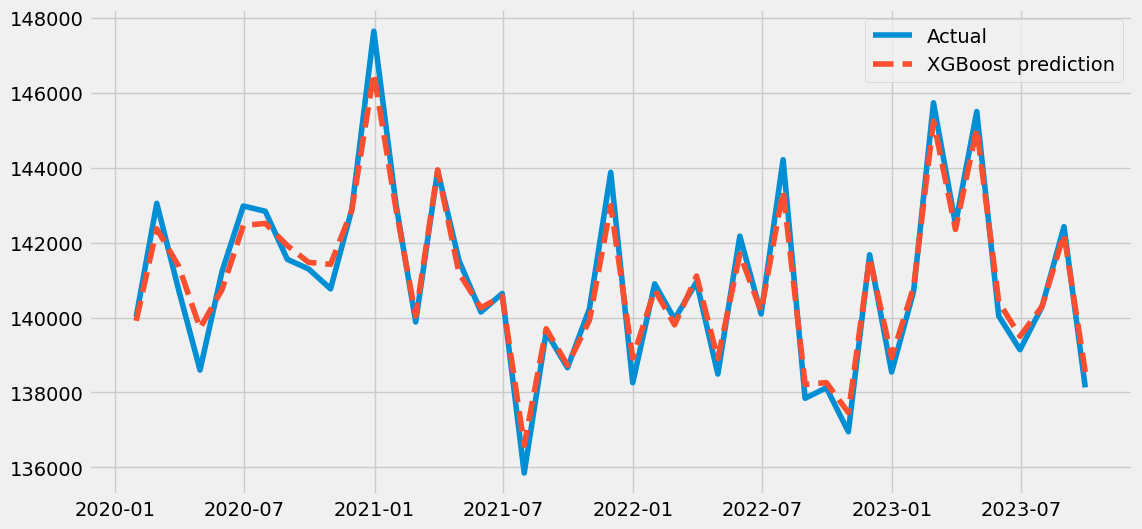

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly['Profit'], label='Actual')
plt.plot(df_monthly.index, df_monthly['prediction'], label='XGBoost prediction', linestyle='dashed')
plt.legend()
plt.show()

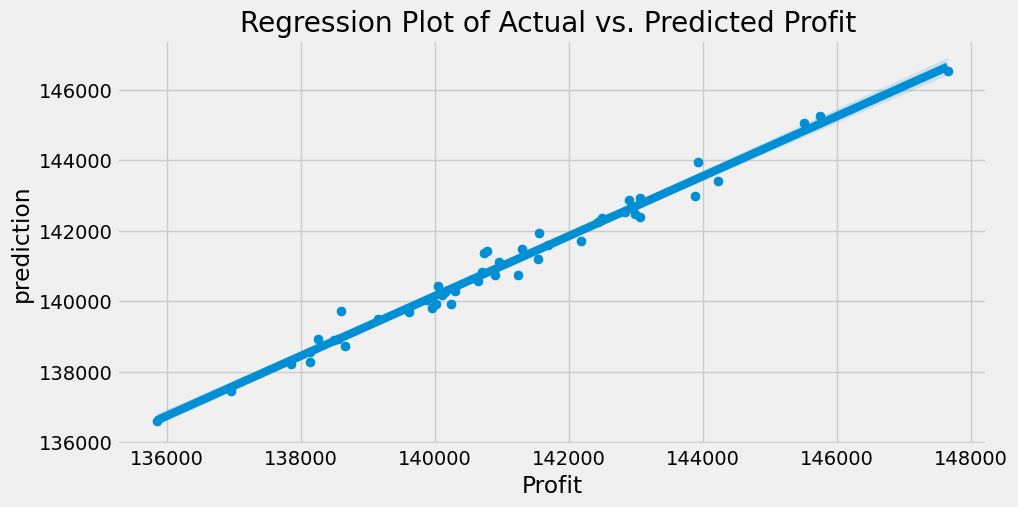

In [74]:
plt.figure(figsize=(10, 5))
plt.scatter(df_monthly['Profit'], df_monthly['prediction'])
plt.xlabel("Profit")
plt.ylabel("prediction")
sns.regplot(x="Profit", y="prediction", data=df_monthly)
plt.title("Regression Plot of Actual vs. Predicted Profit ")
plt.show()